# Distance estimates for STs and PopPunk clustering of E.coli

This notebook assumes that one has already run all scripts matching `umb/scripts/clustering/*.sh`.

In [1]:
from pathlib import Path
from typing import *
import itertools

import numpy as np
import pandas as pd

In [2]:
fastmlst_path = Path("/mnt/e/ecoli_db/chronostrain_files/fastmlst/fastmlst.tsv")
mash_path = Path("/mnt/e/ecoli_db/chronostrain_files/mash/distances.txt")
poppunk_path = Path("/mnt/e/ecoli_db/chronostrain_files/poppunk/refine/refine_clusters.csv")

In [23]:
def load_fastmlst(fastmlst_path: Path) -> pd.DataFrame:
    df_entries = []
    with open(fastmlst_path, "rt") as f:
        for line in f:
            tokens = line.strip().split("\t")
            acc = tokens[0]
            schema = tokens[1]
            st_number = tokens[2]
            df_entries.append({
                'Accession': acc,
                'ST': f'{schema}:{st_number}'
            })
    return pd.DataFrame(df_entries)


class EntryNotFoundError(BaseException):
    def __init__(self, key: str):
        super().__init__(f"Unable to locate key {key}")
        self.key = key


class MashDistanceMatrix:
    def __init__(self, mash_triangle_path: Path):
        with open(mash_triangle_path, "rt") as f:
            n_entries = int(f.readline().strip())
            self.entries = []
            self.matrix = np.zeros((n_entries, n_entries), dtype=float)

            i = 0
            for line in f:
                tokens = line.strip().split("\t")
                self.entries.append(tokens[0])
                for j, d_str in enumerate(tokens[1:]):
                    dist = float(d_str)
                    self.matrix[i, j] = dist
                    self.matrix[j, i] = dist
                i += 1
        self.entry_order = {
            entry: e_idx
            for e_idx, entry in enumerate(self.entries)
        }

    def contains(self, x: str) -> bool:
        return x in self.entry_order

    def get_index_of(self, x: str) -> int:
        try:
            return self.entry_order[x]
        except KeyError:
            raise EntryNotFoundError(x)
    
    def get_dist(self, x: str, y: str) -> float:
        return self.matrix[
            self.get_index_of(x),
            self.get_index_of(y)
        ]

    def n_entries(self) -> int:
        return len(self.entries)
    
    def matrix_shape(self) -> Tuple[int, int]:
        return self.matrix.shape


def load_chronostrain():
    clustering_path = Path("/mnt/e/ecoli_db/chronostrain_files/ecoli.clusters.txt")
    df_entries = []
    with open(clustering_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            tokens = line.strip().split("\t")
            for member_acc in tokens[1].split(','):
                df_entries.append({
                    'Cluster': tokens[0],
                    'Accession': member_acc
                })
    return pd.DataFrame(df_entries)

In [5]:
def fix_poppunk_underscores(x: str):
    tokens = x.split("_")
    prefix = "_".join(tokens[:-1])
    suffix = tokens[-1]
    return f"{prefix}.{suffix}"

poppunk_df = pd.read_csv(poppunk_path)
poppunk_df['Taxon'] = poppunk_df['Taxon'].map(fix_poppunk_underscores)
poppunk_df

,Taxon,Cluster
0,NZ_CP066748.1,1
1,NZ_CP038349.1,1
2,NZ_CP062749.1,1
3,NZ_CP028641.1,1
4,NZ_CP028603.1,1
...,...,...
2058,NZ_AP019856.1,613
2059,NC_017641.1,614
2060,NC_017626.1,615
2061,NC_011415.1,616


In [6]:
fastmlst_df = load_fastmlst(fastmlst_path)
fastmlst_df

,Accession,ST
0,NC_000913.3,ecoli#1:10
1,NC_002695.2,ecoli#1:11
2,NC_004431.1,ecoli#1:73
3,NC_007779.1,ecoli#1:10
4,NC_007946.1,ecoli#1:95
...,...,...
2058,NZ_LT903847.1,ecoli#1:15
2059,NZ_LT906474.1,ecoli#1:1721
2060,NZ_OU342919.1,ecoli#1:1308
2061,NZ_OU701449.1,ecoli#1:38


In [7]:
dists = MashDistanceMatrix(mash_path)
dists.matrix_shape()

(2063, 2063)

In [21]:
chronostrain_df = load_chronostrain()
chronostrain_df

,Cluster,Accession
0,NZ_CP043357.1,NZ_CP043357.1
1,NZ_CP043357.1,NZ_CP036300.1
2,NZ_CP043357.1,NZ_CP029384.2
3,NZ_CP055247.1,NZ_CP055247.1
4,NZ_CP055247.1,NZ_CP056451.1
...,...,...
5386,NZ_CP085060.1,NZ_CP085060.1
5387,NC_018661.1,NC_018661.1
5388,NZ_CP014004.1,NZ_CP014004.1
5389,NZ_CP050646.1,NZ_CP050646.1


# Compute poppunk dists.

In [31]:
df_entries = []
for cluster_id, cluster_section in poppunk_df.groupby("Cluster"):
    accs = list(cluster_section['Taxon'])
    cluster_dists = np.array([
        dists.get_dist(x, y)
        for x, y in itertools.combinations(accs, r=2)
    ])
    df_entries.append({
        'Cluster': cluster_id,
        'MeanWithinDist': np.mean(cluster_dists)
    })

poppunk_dist_df = pd.DataFrame(df_entries)
del df_entries

/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


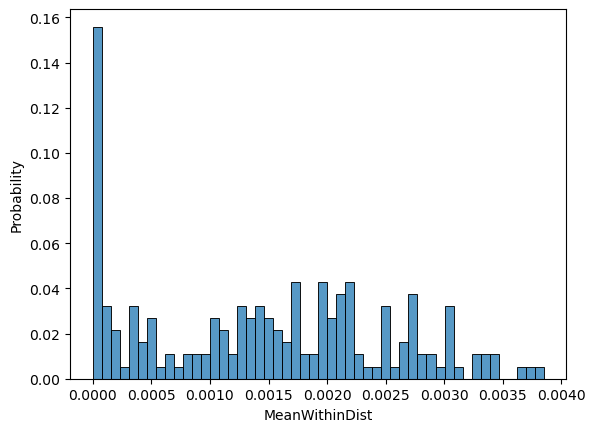

In [32]:
import seaborn as sb

ax = sb.histplot(
    poppunk_dist_df,
    x='MeanWithinDist',
    bins=50,
    stat='probability'
)
# sb.kdeplot(
#     df,
#     x='MeanDist',
#     ax=ax
# )

# Compute within-ST dists.

In [33]:
df_entries = []
for cluster_id, cluster_section in fastmlst_df.groupby("ST"):
    accs = list(cluster_section['Accession'])
    cluster_dists = np.array([
        dists.get_dist(x, y)
        for x, y in itertools.combinations(accs, r=2)
    ])
    df_entries.append({
        'ST': cluster_id,
        'MeanWithinDist': np.mean(cluster_dists)
    })

st_dist_df = pd.DataFrame(df_entries)
del df_entries

/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


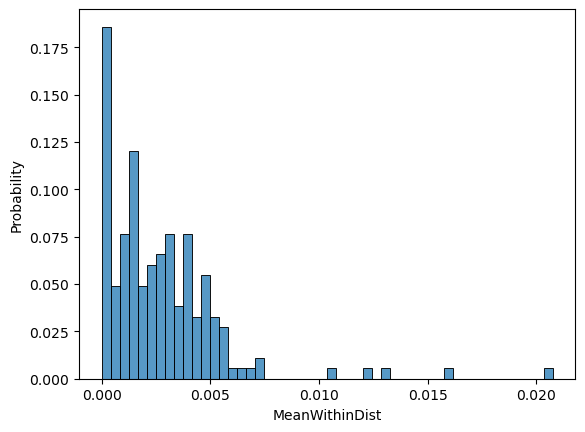

In [34]:
import seaborn as sb

ax = sb.histplot(
    st_dist_df,
    x='MeanWithinDist',
    bins=50,
    stat='probability'
)

# Compute within-cluster dists for ChronoStrain.

In [35]:
index_df = pd.read_csv("/mnt/e/ecoli_db/ref_genomes/index.tsv", sep='\t')
display(index_df)
ecoli_subset = chronostrain_df.merge(
    index_df.loc[(index_df['Genus'] == 'Escherichia') & (index_df['Species'] == 'coli'), ['Genus', 'Species', 'Accession']], 
    on='Accession', 
    how='inner'
)


df_entries = []
for cluster_id, cluster_section in ecoli_subset.groupby("Cluster"):
    accs = list(cluster_section['Accession'])
    cluster_dists = np.array([
        dists.get_dist(x, y)
        for x, y in itertools.combinations(accs, r=2)
    ])
    df_entries.append({
        'Cluster': cluster_id,
        'MeanWithinDist': np.mean(cluster_dists)
    })

chronostrain_dist_df = pd.DataFrame(df_entries)
del df_entries

,Genus,Species,Strain,Accession,Assembly,SeqPath,ChromosomeLen,GFF
0,Buttiauxella,agrestis,DSM_9389,NZ_AP023184.1,GCF_013234275.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,4566254,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...
1,Buttiauxella,sp.,3AFRM03,NZ_CP033076.1,GCF_003675305.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,5319710,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...
2,Cedecea,lapagei,NCTC11466,NZ_LR134201.1,GCF_900635955.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,4778444,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...
3,Cedecea,neteri,FDAARGOS_392,NZ_CP023525.1,GCF_002393445.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,5214802,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...
4,Cedecea,neteri,M006,NZ_CP009458.1,GCF_000758305.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,4965436,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...
...,...,...,...,...,...,...,...,...
5401,Shigella,sonnei,SE6-1,NZ_CP055292.1,GCF_013374815.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,4762774,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...
5402,Shimwellia,blattae,DSM_4481,NC_017910.1,GCF_000262305.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,4158725,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...
5403,Shimwellia,blattae,NCTC10965,NZ_LR133996.1,GCF_900635135.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,4154215,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...
5404,Shimwellia,blattae,NCTC12127,NZ_LR134215.1,GCF_900636035.1,/mnt/e/ecoli_db/ref_genomes/human_readable/ref...,4152791,/mnt/e/ecoli_db/ref_genomes/refseq/bacteria/GC...


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


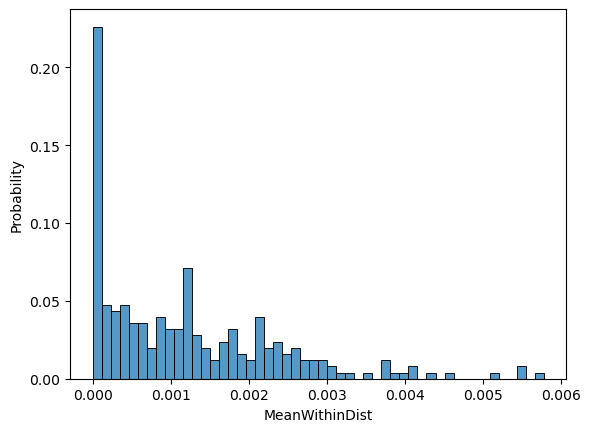

In [36]:
import seaborn as sb

ax = sb.histplot(
    chronostrain_dist_df,
    x='MeanWithinDist',
    bins=50,
    stat='probability'
)

# Comparison

PopPUNK 0.0014784602499999999
ST 0.00216198
ChronoStrain 0.0009529737209359606


/tmp/ipykernel_347947/3801127607.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


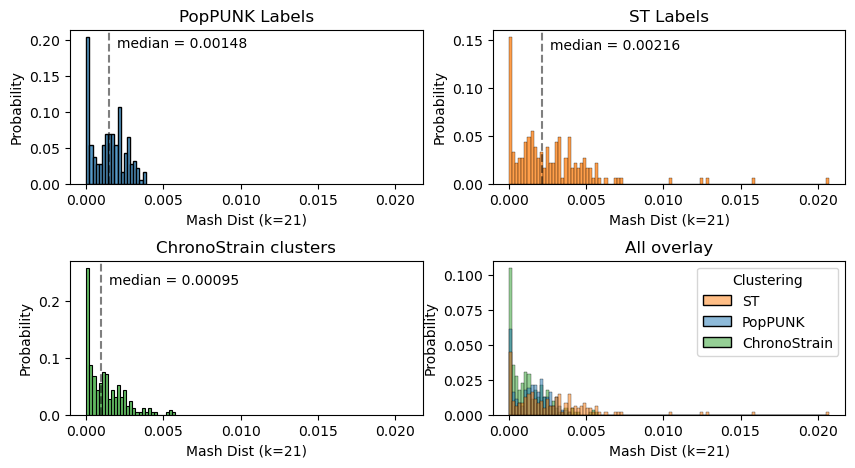

In [40]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


fig, ax = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'hspace': 0.5})
palette = {
    'PopPUNK': 'tab:blue',
    'ST': 'tab:orange',
    'ChronoStrain': 'tab:green'
}


sb.histplot(
    poppunk_dist_df,
    x='MeanWithinDist',
    binwidth=0.0002,
    stat='probability',
    ax=ax[0,0],
    color=palette['PopPUNK']
)
median = np.nanmedian(poppunk_dist_df['MeanWithinDist'])
print("PopPUNK", median)
ax[0,0].axvline(median, color='black', linestyle='--', alpha=0.5)
ax[0,0].text(median + 0.0005, 0.19, 'median = {:.5f}'.format(median))
ax[0,0].set_title("PopPUNK Labels")
ax[0,0].set_xlabel("Mash Dist (k=21)")

sb.histplot(
    st_dist_df,
    x='MeanWithinDist',
    binwidth=0.0002,
    stat='probability',
    ax=ax[0,1],
    color=palette['ST']
)
median = np.nanmedian(st_dist_df['MeanWithinDist'])
print("ST", median)
ax[0,1].axvline(median, color='black', linestyle='--', alpha=0.5)
ax[0,1].text(median + 0.0005, 0.14, 'median = {:.5f}'.format(median))
ax[0,1].set_title("ST Labels")
ax[0,1].set_xlabel("Mash Dist (k=21)")


sb.histplot(
    chronostrain_dist_df,
    x='MeanWithinDist',
    binwidth=0.0002,
    stat='probability',
    ax=ax[1,0],
    color=palette['ChronoStrain']
)
median = np.nanmedian(chronostrain_dist_df['MeanWithinDist'])
print("ChronoStrain", median)
ax[1,0].axvline(median, color='black', linestyle='--', alpha=0.5)
ax[1,0].text(median + 0.0005, 0.23, 'median = {:.5f}'.format(median))
ax[1,0].set_title("ChronoStrain clusters")
ax[1,0].set_xlabel("Mash Dist (k=21)")
# chronostrain_dist_df


combined_dist_df = pd.concat([
    st_dist_df.assign(Clustering='ST'), 
    poppunk_dist_df.assign(Clustering='PopPUNK'),
    chronostrain_dist_df.assign(Clustering='ChronoStrain')
], ignore_index=True)

sb.histplot(
    combined_dist_df,
    x='MeanWithinDist',
    binwidth=0.0002,
    stat='probability',
    hue='Clustering',
    ax=ax[1,1],
    palette=palette
)
ax[1,1].set_title("All overlay")
ax[1,1].set_xlabel("Mash Dist (k=21)")


ax[0,0].sharex(ax[1,1])
ax[0,1].sharex(ax[1,1])
ax[1,0].sharex(ax[1,1])

fig.tight_layout()
plt.savefig("clustering_mash_estimates.pdf")